## Jupyter notebook version of "fno_navier_stokes_1214.py"

In [6]:
import os
import math
import time
import argparse
import numpy as np
import scipy.io
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt



In [7]:
def set_seed(seed=0):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


class SpectralConv2d(nn.Module):
    """2D Fourier layer"""
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1
        self.modes2 = modes2

        self.scale = 1 / (in_channels * out_channels)
        self.weights1 = nn.Parameter(
            self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, 2)
        )
        self.weights2 = nn.Parameter(
            self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, 2)
        )

    def compl_mul2d(self, input, weights):
        """Complex multiplication"""
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        B, C, H, W = x.shape
        
        # Fourier transform
        x_ft = torch.fft.rfft2(x)
        
        # Multiply relevant Fourier modes
        out_ft = torch.zeros(B, self.out_channels, H, W//2 + 1, 
                            dtype=torch.cfloat, device=x.device)
        
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], 
                           torch.view_as_complex(self.weights1))
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2],
                           torch.view_as_complex(self.weights2))
        
        # Inverse Fourier transform
        x = torch.fft.irfft2(out_ft, s=(H, W))
        return x


In [8]:
class FNO2d(nn.Module):
    def __init__(self, modes1, modes2, width, n_layers=4, in_channels=3, out_channels=3):
        super().__init__()
        
        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.n_layers = n_layers
        
        self.fc0 = nn.Linear(in_channels + 2, self.width)  # +2 for (x,y) encoding
        
        self.conv_layers = nn.ModuleList()
        self.w_layers = nn.ModuleList()
        
        for _ in range(n_layers):
            self.conv_layers.append(SpectralConv2d(self.width, self.width, 
                                                   self.modes1, self.modes2))
            self.w_layers.append(nn.Conv2d(self.width, self.width, 1))
        
        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, out_channels)

    def forward(self, x, grid):
        """
        x: (B, H, W, C) input features
        grid: (B, H, W, 2) mesh coordinates
        """
        # Combine input with grid
        x = torch.cat([x, grid], dim=-1)  # (B, H, W, C+2)
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)  # (B, width, H, W)
        
        # FNO layers
        for conv, w in zip(self.conv_layers, self.w_layers):
            x1 = conv(x)
            x2 = w(x)
            x = x1 + x2
            x = F.gelu(x)
        
        # Output
        x = x.permute(0, 2, 3, 1)  # (B, H, W, width)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x


In [9]:
class CylinderWakeData:
    def __init__(self, mat_path, nx=100, ny=50):
        data = scipy.io.loadmat(mat_path)
        self.U_star = data["U_star"]  # (N,2,T)
        self.p_star = data["p_star"]  # (N,T)
        self.X_star = data["X_star"]  # (N,2)
        self.t_star = data["t"]       # (T,1)
        
        self.N = self.X_star.shape[0]
        self.T = self.t_star.shape[0]
        self.nx = nx
        self.ny = ny
        
        # Reshape to grid (assuming structured grid)
        self.x = self.X_star[:, 0].reshape(ny, nx)
        self.y = self.X_star[:, 1].reshape(ny, nx)
        
    def get_snapshot(self, t_idx):
        """Get u,v,p at time index t_idx as grid"""
        u = self.U_star[:, 0, t_idx].reshape(self.ny, self.nx)
        v = self.U_star[:, 1, t_idx].reshape(self.ny, self.nx)
        p = self.p_star[:, t_idx].reshape(self.ny, self.nx)
        return u, v, p
    
    def get_training_data(self, t_indices, n_train_points=2500):
        """Get training data from multiple time snapshots"""
        # Flatten all snapshots
        all_x, all_y, all_t = [], [], []
        all_u, all_v, all_p = [], [], []
        
        for t_idx in t_indices:
            u, v, p = self.get_snapshot(t_idx)
            t_val = self.t_star[t_idx, 0]
            
            all_x.append(self.x.flatten())
            all_y.append(self.y.flatten())
            all_t.append(np.full(self.N, t_val))
            all_u.append(u.flatten())
            all_v.append(v.flatten())
            all_p.append(p.flatten())
        
        all_x = np.concatenate(all_x)
        all_y = np.concatenate(all_y)
        all_t = np.concatenate(all_t)
        all_u = np.concatenate(all_u)
        all_v = np.concatenate(all_v)
        all_p = np.concatenate(all_p)
        
        # Random sample
        idx = np.random.choice(len(all_x), n_train_points, replace=False)
        
        return (np.stack([all_x[idx], all_y[idx], all_t[idx]], axis=1),
                np.stack([all_u[idx], all_v[idx], all_p[idx]], axis=1))



In [10]:
def plot_results(res, history, args, save_dir):
    """Create comprehensive result plots for FNO"""
    os.makedirs(save_dir, exist_ok=True)
    
    # 1. Training curves
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    ax = axes[0]
    ax.semilogy(history["epoch"], history["train_loss"])
    ax.set_title("Training Loss")
    ax.set_xlabel("Epoch")
    ax.grid(True, alpha=0.3)
    
    ax = axes[1]
    ax.semilogy(history["epoch"], history["test_mse"])
    ax.set_title("Test MSE")
    ax.set_xlabel("Epoch")
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'training_curves.png'), dpi=150, bbox_inches='tight')
    plt.close()
    
    # 2. Prediction visualization
    uvp_true = res["uvp_true"]  # (H, W, 3)
    uvp_pred = res["uvp_pred"]  # (H, W, 3)
    
    H, W = uvp_true.shape[:2]
    x = res["x"]  # (H, W)
    y = res["y"]  # (H, W)
    extent = [x.min(), x.max(), y.min(), y.max()]
    
    fig, axes = plt.subplots(3, 3, figsize=(14, 10))
    
    for i, var in enumerate(['u', 'v', 'p']):
        true_val = uvp_true[:, :, i]
        pred_val = uvp_pred[:, :, i]
        err_val = np.abs(pred_val - true_val)
        
        ax = axes[i, 0]
        im = ax.imshow(true_val, origin='lower', aspect='auto', 
                      extent=extent, cmap='viridis', interpolation='bilinear')
        ax.set_title(f'{var} (True)')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        plt.colorbar(im, ax=ax)
        
        ax = axes[i, 1]
        im = ax.imshow(pred_val, origin='lower', aspect='auto',
                      extent=extent, cmap='viridis', interpolation='bilinear')
        ax.set_title(f'{var} (Pred)')
        ax.set_xlabel('x')
        plt.colorbar(im, ax=ax)
        
        ax = axes[i, 2]
        im = ax.imshow(err_val, origin='lower', aspect='auto',
                      extent=extent, cmap='hot', interpolation='bilinear')
        ax.set_title(f'{var} (Abs Error)')
        ax.set_xlabel('x')
        plt.colorbar(im, ax=ax)
    
    plt.suptitle(f"FNO | MSE={res['mse']:.3e} | t_index={args.test_t_idx}", y=0.995)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'predictions.png'), dpi=150, bbox_inches='tight')
    # plt.close()
    
    print(f"Saved plots to {save_dir}/")




In [11]:
def train_fno(args):
    device = torch.device(args.device)
    set_seed(args.seed)
    
    data = CylinderWakeData(args.data_path)
    
    # Create grid
    grid = torch.tensor(np.stack([data.x, data.y], axis=-1), 
                       dtype=torch.float32, device=device).unsqueeze(0)
    
    # Get training snapshot
    u_train, v_train, p_train = data.get_snapshot(args.train_t_idx)
    uvp_train = np.stack([u_train, v_train, p_train], axis=-1)
    uvp_train = torch.tensor(uvp_train, dtype=torch.float32, device=device).unsqueeze(0)
    
    # Get test snapshot
    u_test, v_test, p_test = data.get_snapshot(args.test_t_idx)
    uvp_test = np.stack([u_test, v_test, p_test], axis=-1)
    uvp_test = torch.tensor(uvp_test, dtype=torch.float32, device=device).unsqueeze(0)
    
    # Model
    model = FNO2d(modes1=args.modes, modes2=args.modes, width=args.width, 
                  n_layers=args.n_layers, in_channels=3, out_channels=3).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, 
                                 weight_decay=args.weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, args.epochs)
    
    print(f"\nFNO Training")
    print(f"Device: {device}")
    print(f"Grid size: {data.ny}x{data.nx}")
    print(f"Modes: {args.modes}, Width: {args.width}, Layers: {args.n_layers}")
    print(f"Train snapshot: t={args.train_t_idx}, Test snapshot: t={args.test_t_idx}")
    
    history = {"epoch": [], "train_loss": [], "test_mse": []}
    best_test = float('inf')
    
    for epoch in range(1, args.epochs + 1):
        model.train()
        optimizer.zero_grad()
        
        pred = model(uvp_train, grid)
        loss = F.mse_loss(pred, uvp_train)
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        if epoch % args.print_every == 0 or epoch == 1:
            model.eval()
            with torch.no_grad():
                pred_test = model(uvp_test, grid)
                test_mse = F.mse_loss(pred_test, uvp_test).item()
            
            print(f"[{epoch:05d}/{args.epochs}] train_loss={loss.item():.3e} | "
                  f"test_mse={test_mse:.3e}")
            
            history["epoch"].append(epoch)
            history["train_loss"].append(loss.item())
            history["test_mse"].append(test_mse)
            
            if test_mse < best_test:
                best_test = test_mse
                if args.save_path:
                    os.makedirs(os.path.dirname(args.save_path), exist_ok=True)
                    torch.save({
                        'model': model.state_dict(),
                        'epoch': epoch,
                        'test_mse': best_test,
                        'history': history,
                    }, args.save_path)
    
    print(f"\nBest test MSE: {best_test:.3e}")
    
    # Final evaluation and plotting
    model.eval()
    with torch.no_grad():
        pred_test = model(uvp_test, grid)
    
    res = {
        'x': data.x,
        'y': data.y,
        'uvp_true': uvp_test.squeeze(0).cpu().numpy(),
        'uvp_pred': pred_test.squeeze(0).cpu().numpy(),
        'mse': best_test
    }
    
    save_dir = os.path.join(os.path.dirname(args.save_path), 'fno_plots')
    plot_results(res, history, args, save_dir)
    
    return model, history



FNO Training
Device: cpu
Grid size: 50x100
Modes: 12, Width: 32, Layers: 4
Train snapshot: t=0, Test snapshot: t=100
[00001/5000] train_loss=3.201e-01 | test_mse=3.122e-01
[00500/5000] train_loss=5.966e-05 | test_mse=6.979e-02
[01000/5000] train_loss=3.406e-05 | test_mse=7.225e-02
[01500/5000] train_loss=3.901e-05 | test_mse=7.372e-02
[02000/5000] train_loss=2.172e-05 | test_mse=7.437e-02
[02500/5000] train_loss=1.943e-05 | test_mse=7.474e-02
[03000/5000] train_loss=1.777e-05 | test_mse=7.496e-02
[03500/5000] train_loss=1.683e-05 | test_mse=7.510e-02
[04000/5000] train_loss=1.636e-05 | test_mse=7.518e-02
[04500/5000] train_loss=1.617e-05 | test_mse=7.521e-02
[05000/5000] train_loss=1.613e-05 | test_mse=7.521e-02

Best test MSE: 6.979e-02
Saved plots to checkpoints\fno_plots/


(FNO2d(
   (fc0): Linear(in_features=5, out_features=32, bias=True)
   (conv_layers): ModuleList(
     (0-3): 4 x SpectralConv2d()
   )
   (w_layers): ModuleList(
     (0-3): 4 x Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
   )
   (fc1): Linear(in_features=32, out_features=128, bias=True)
   (fc2): Linear(in_features=128, out_features=3, bias=True)
 ),
 {'epoch': [1, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000],
  'train_loss': [0.32012686133384705,
   5.965954915154725e-05,
   3.405512325116433e-05,
   3.9006208680802956e-05,
   2.1720303266192786e-05,
   1.9429566236794926e-05,
   1.7765039956429973e-05,
   1.6829419109853916e-05,
   1.635843000258319e-05,
   1.6166086425073445e-05,
   1.6133428289322183e-05],
  'test_mse': [0.31219595670700073,
   0.06979185342788696,
   0.07225468754768372,
   0.07371601462364197,
   0.07436622679233551,
   0.07473728805780411,
   0.07495961338281631,
   0.07510282844305038,
   0.07517760246992111,
   0.07520784437656403,
   0.0

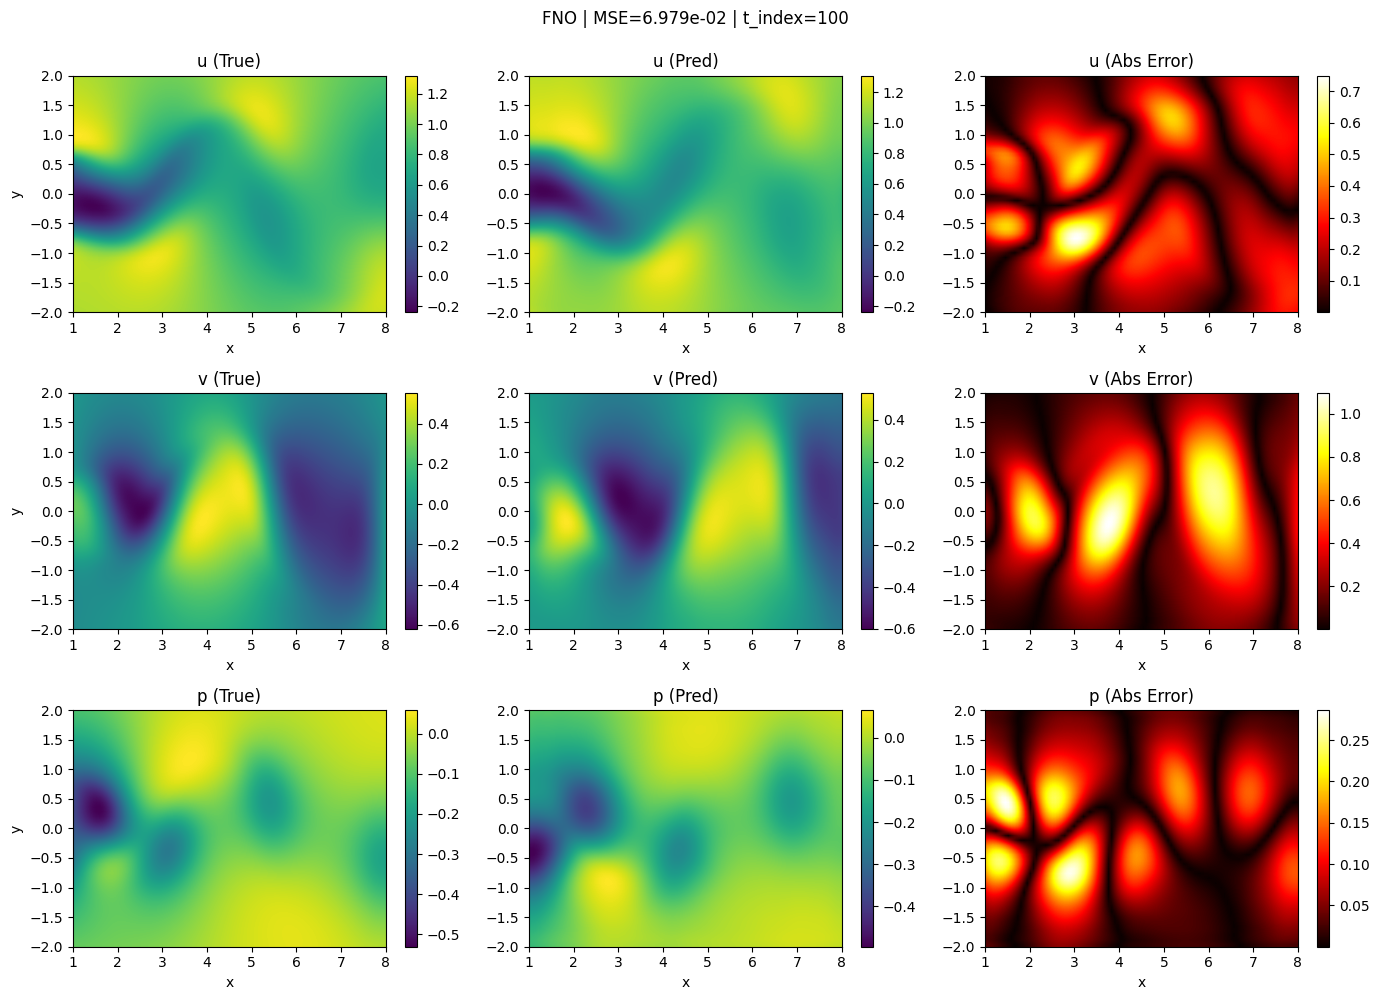

In [12]:
class Config:
    data_path = "./cylinder_nektar_wake.mat"
    device = "cpu"
    seed = 0
    modes = 12
    width = 32
    n_layers = 4
    train_t_idx = 0
    test_t_idx = 100
    epochs = 5000
    lr = 1e-3
    weight_decay = 1e-4
    print_every = 500
    save_path = "checkpoints/fno_ns.pt"

args = Config()

# Train model
train_fno(args)